## Imports and dependencies

In [55]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder,StandardScaler,PowerTransformer
from sklearn.model_selection import train_test_split,RandomizedSearchCV
from imblearn.over_sampling import SMOTE
from scipy.stats import uniform, randint
# !pip install pygwalker --upgrade
# import pygwalker as pyg
import warnings
# ! pip install ydata_profiling
# from ydata_profiling import ProfileReport
warnings.filterwarnings("ignore")
# !pip install scikit-learn imbalanced-learn
from sklearn.preprocessing import PowerTransformer, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from imblearn.pipeline import Pipeline
from imblearn.ensemble import BalancedRandomForestClassifier
import xgboost as xgb
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, f1_score, make_scorer

## Data Exploration

In [56]:
# read the df from the excel sheet
df=pd.read_excel("Road Accidents.xlsx")

In [57]:
# print 1st 3 rows of the df
df.head(3)

,Reference Number,Easting,Northing,Number of Vehicles,Accident Date,Time (24hr),1st Road Class,Road Surface,Lighting Conditions,Weather Conditions,Casualty Class,Casualty Severity,Sex of Casualty,Age of Casualty,Type of Vehicle
0,110016014,443330,439205,2,2011-01-12,712,A(M),Wet / Damp,Darkness: street lighting unknown,Raining without high winds,Driver,Slight,Male,62,Car
1,110016024,425059,433371,2,2011-01-12,830,Unclassified,Wet / Damp,Daylight: street lights present,Raining without high winds,Driver,Slight,Female,39,Car
2,110016533,420683,434373,1,2011-01-12,1215,A,Wet / Damp,Daylight: street lights present,Fine without high winds,Pedestrian,Serious,Male,66,Car


In [58]:
# print df info to check dtatypes and missings
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2604 entries, 0 to 2603
Data columns (total 15 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   Reference Number     2604 non-null   int64         
 1   Easting              2604 non-null   int64         
 2   Northing             2604 non-null   int64         
 3   Number of Vehicles   2604 non-null   int64         
 4   Accident Date        2604 non-null   datetime64[ns]
 5   Time (24hr)          2604 non-null   int64         
 6   1st Road Class       2604 non-null   object        
 7   Road Surface         2604 non-null   object        
 8   Lighting Conditions  2604 non-null   object        
 9   Weather Conditions   2604 non-null   object        
 10  Casualty Class       2604 non-null   object        
 11  Casualty Severity    2604 non-null   object        
 12  Sex of Casualty      2604 non-null   object        
 13  Age of Casualty      2604 non-nul

There is no missing values in the dataset, and no invalid datatypes

We have 2k+ responses in the dataset

In [59]:
# print summary statistics of nominal columns
df.describe()

,Reference Number,Easting,Northing,Number of Vehicles,Accident Date,Time (24hr),Age of Casualty
count,2.604000e+03,2604.000000,2604.000000,2604.000000,2604,2604.000000,2604.000000
mean,1.102817e+08,430127.497696,434243.245392,1.959677,2011-07-08 15:33:27.373271808,1406.221966,35.297235
min,1.100189e+07,415290.000000,424216.000000,1.000000,2011-01-12 00:00:00,5.000000,0.000000
25%,1.101720e+08,427136.500000,431754.500000,2.000000,2011-04-12 18:00:00,1044.500000,21.000000
50%,1.103125e+08,430098.000000,434223.000000,2.000000,2011-07-08 00:00:00,1455.000000,32.000000
75%,1.104574e+08,432513.000000,436165.000000,2.000000,2011-10-05 00:00:00,1750.000000,46.000000
max,1.200074e+08,444895.000000,449409.000000,8.000000,2011-12-31 00:00:00,2355.000000,95.000000
std,1.971720e+06,5118.276964,4383.146273,0.801163,NaN,509.065769,18.491683


Insights: <br>
<ul>Data is collected within the time interval (2011-01-12 00:00:00, 2011-12-31 00:00:00)</ul>
<ul>The max number of vehicles involved in accidents were up to 8</ul>
<ul>The min time of accidents was 5 hours, and the max ws up to +2300 hours</ul>
<ul>The age of passenger involved with accidents starts with 0; we assume this indicated new born babies</ul>

## Data Cleaning

In [60]:
# convert the "Accident Date" col to datetime data type
# df["Accident Date"]=pd.to_datetime(df["Accident Date"])

In [61]:
## check duplicates
print(df.duplicated().sum())
df.drop_duplicates(inplace=True)

17


We see that there are 17 rows out of 2.5k+ are duplicated, we will drop them

In [62]:
## check for outliers
## select nominal cols
numeric_df=df.select_dtypes(include=np.number)
# drop ids, and location columns
numeric_df.drop(["Reference Number", "Easting","Northing"], axis=1,inplace=True)
c = 2
r = (len(numeric_df.columns) + c - 1) // c
fig = make_subplots(rows=r, cols=c, subplot_titles=numeric_df.columns)

# plot a box plot
for index, column in enumerate(numeric_df.columns):
    trace = go.Box(y=numeric_df[column], name=column, marker_color='mediumslateblue')
    fig.add_trace(trace, row=(index // c) + 1, col=(index % c) + 1)

# set layout
fig.update_layout(height=300 * r, width=800, title_text="Box Plots of Columns:")
fig.show()

Convert continuos age reading into age groups

We see that:
- The number of vehicles which deviates from 2 are out of range records  aka outliers, We will keep those outlier points and perform EDA
- the hours of the incidents col has no outliers data points.
- people whose age is more than 80 yrs are considered as out of range records, we will handle this outliers by creating ege group, hence converting those continuou values into discrete.


In [63]:
# create a new col for each group that combines groups by each 10 years
def handle_age(age):
    if age <70:
        return f"{(age//10 )* 10}-{((age//10 )* 10)+9}"
    else:
        return "+70"
df['age_group']=df['Age of Casualty'].apply(handle_age)

In [64]:
df['age_group']

,age_group
0,60-69
1,30-39
2,60-69
3,30-39
4,20-29
...,...
2599,10-19
2600,10-19
2601,+70
2602,20-29


In [65]:
# plot age group
age_group_counts = df['age_group'].value_counts()
fig = go.Figure(data=[go.Bar(x=age_group_counts.index, y=age_group_counts.values)])
fig.update_layout(
    title='Age Group Distribution',
    xaxis_title='Age Group',
    yaxis_title='Count',
    bargap=0.1
)

fig.show()

## EDA

In [11]:
# useful lib for initial quick eda
# profile=ProfileReport(df, title='car accidents')
# profile.to_file(output_file='car accidents.html')
# pyg.walk(df)

In [53]:
# names of df columns
df.columns

Index(['Reference Number', 'Easting', 'Northing', 'Number of Vehicles',
       'Accident Date', 'Time (24hr)', '1st Road Class', 'Road Surface',
       'Lighting Conditions', 'Weather Conditions', 'Casualty Class',
       'Casualty Severity', 'Sex of Casualty', 'Age of Casualty',
       'Type of Vehicle', 'age_group'],
      dtype='object')

In [66]:
# check value_couts for columns
## plot the distribution of columns of interest( without the id, and location coordinates)
dist_cols_df=df.drop(["Reference Number","Accident Date",
                      "Easting","Northing",
                      "Time (24hr)", "Age of Casualty"], axis=1)
# make subplots
c = 2
r = (len(dist_cols_df.columns) + c - 1) // c  #
fig = make_subplots(rows=r, cols=c,
                    subplot_titles=dist_cols_df.columns,
                    vertical_spacing=0.1, horizontal_spacing=0.1)
# iterate to col in df to plot a bar graph in subplots
for index, col in enumerate(dist_cols_df.columns):
    data = dist_cols_df[col].value_counts().reset_index()
    data.columns = [col, 'count']
    # sort values in each col ascendingly
    data = data.sort_values(by='count', ascending=False)
    row = index // c + 1
    col_index = index % c + 1
    # bar graph code, with static color
    fig.add_trace(go.Bar(x=data['count'], y=data[col],
                         orientation='h',
                         marker_color='mediumslateblue'),
                   row=row, col=col_index)
# set up the layout
fig.update_layout(
    height=300 * r,
    showlegend=False,
    margin=dict(l=100, r=100, t=50, b=50),
    autosize=True,
    template='plotly_white'
)
fig.show()

Insights:

<ul>the most accidents involve a single vehicle. or 2</ul>
<ul>the majority of casualties are slight; serious casualties are significantly fewer; fatal casualties are the least frequent.class severity is extrmely imbalanced</ul>
<ul>most accidents occur during daylight with street lights present and  lit; darkness with no street lighting has fewer accidents.</ul>

<ul>the majority of accidents occur during fine weather without high winds, and this is might be due data sample we have, we see this might be biased insight</ul>

<ul>passengers also represent a significant portion of casualties. while pedestrians are the least frequent casualties compared to drivers and passengers.</ul>



<ul>male casualties are slightly more frequent than female casualties.</ul>

<ul>cars are involved in the majority of accidents.</ul>

<ul>Accidents are most frequent during fine weather without high winds.</ul>
<ul> drivers are the most common casualties.</ul>
<ul> the most age group that is involved in the incidents are the age group from 20 to 29</ul>

Insights:

Cars are the most common vehicle type involved in accidents, with over 1500 occurrences.the highest number of casualties falls under the "Slight" severity category ( this is consistent across almost all vehicle types)




We will use this info to group vehicles based on vehicle type

In [67]:
#we found that the road surface has an invalid readings of 5
print(df[df['Road Surface']== 5].shape[0])
df=df[df['Road Surface']!= 5]

1


We drop this 1 record from our dataframe

In [15]:
df.head(1)

,Reference Number,Easting,Northing,Number of Vehicles,Accident Date,Time (24hr),1st Road Class,Road Surface,Lighting Conditions,Weather Conditions,Casualty Class,Casualty Severity,Sex of Casualty,Age of Casualty,Type of Vehicle,age_group
0,110016014,443330,439205,2,2011-01-12,712,A(M),Wet / Damp,Darkness: street lighting unknown,Raining without high winds,Driver,Slight,Male,62,Car,60-69


In [68]:
# histogram wof actual hours vs Lighting Conditions
fig = px.histogram(df, x='Time (24hr)', nbins=20,
                   color= 'Lighting Conditions', title='Accidents Time (24hr)')
fig.update_layout(
    xaxis_title='Hours',
    yaxis_title='Count',
    bargap=0.2,
)
fig.show()

- We find that the more the incidents hours, are the more the lightning condition is darker even if street lights were on
- time in hours is skwed, this will be considered will scaling the data

In [69]:
# histogram wof actual hours vs Lighting Conditions
fig = px.histogram(df, x='Casualty Class', nbins=20,
                   color= 'Casualty Severity', title='Class Vs Severity')
fig.update_layout(
    xaxis_title='Passengers class',
    yaxis_title='Count',
    bargap=0.2,
)
fig.show()

In [70]:

fig = px.histogram(df, x='Casualty Class', nbins=20,
                   color='Casualty Severity', title='Class Vs Severity',
                   facet_col='Sex of Casualty')
fig.update_layout(
    xaxis_title='Passengers class',
    yaxis_title='Count',
    bargap=0.2
)
fig.show()

In [71]:
df.columns

Index(['Reference Number', 'Easting', 'Northing', 'Number of Vehicles',
       'Accident Date', 'Time (24hr)', '1st Road Class', 'Road Surface',
       'Lighting Conditions', 'Weather Conditions', 'Casualty Class',
       'Casualty Severity', 'Sex of Casualty', 'Age of Casualty',
       'Type of Vehicle', 'age_group'],
      dtype='object')

In [72]:
df['Sex of Casualty'].value_counts()

,count
Sex of Casualty,
Male,1538
Female,1048


Males are most probalby to be the driver, driver accidets is the most frequent accidents.
Males are prone to face severt acciednets th

## Feature Engineering

In [73]:
df['Type of Vehicle'].value_counts()

,count
Type of Vehicle,
Car,1783
Pedal cycle,255
Bus or coach (17 or more passenger seats),169
Taxi/Private hire car,82
Goods vehicle 3.5 tonnes mgw and under,73
Motorcycle over 50cc and up to 125cc,71
Motorcycle over 500cc,60
M/cycle 50cc and under,28
Motorcycle over 125cc and up to 500cc,20


In [74]:
# re-categorise vehicles according to similar types
vehicle_group_mapping = {
    'Car': 'Car',
    'Taxi/Private hire car': 'Car',
    'Pedal cycle': 'Two-Wheeled Vehicle',
    'Motorcycle over 50cc and up to 125cc': 'Two-Wheeled Vehicle',
    'Motorcycle over 500cc': 'Two-Wheeled Vehicle',
    'M/cycle 50cc and under': 'Two-Wheeled Vehicle',
    'Motorcycle over 125cc and up to 500cc': 'Two-Wheeled Vehicle',
    'Bus or coach (17 or more passenger seats)': 'Public Transportation',
    'Minibus (8 – 16 passenger seats)': 'Public Transportation',
    'Goods vehicle 3.5 tonnes mgw and under': 'Other Vehicle',
    'Goods vehicle 7.5 tonnes mgw and over': 'Other Vehicle',
    'Goods vehicle over 3.5 tonnes and under 7.5 tonnes mgw': 'Other Vehicle',
    'Other Vehicle': 'Other Vehicle',
    'Ridden horse': 'Other Vehicle',
    'Agricultural vehicle (includes diggers etc.)': 'Other Vehicle'
}

df['vehicle_group'] = df['Type of Vehicle'].map(vehicle_group_mapping)
df['vehicle_group'].value_counts()

,count
vehicle_group,
Car,1865
Two-Wheeled Vehicle,434
Public Transportation,181
Other Vehicle,106


We now have 4 categories

In [75]:
# label encode the data
# separate numerical and nominal data
nominal_cols = df.select_dtypes(include=['object', 'category']).columns
# apply Label Encoding to nominal data
label_encoders = {}
for col in nominal_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col].astype(str))
    label_encoders[col] = le

In [76]:
# we will drop the Reference Number,Eastingm Accident Date, and Northing columns
df.drop(["Reference Number","Easting","Northing","Accident Date"], axis=1,inplace=True)

In [77]:
df.head(1)

,Number of Vehicles,Time (24hr),1st Road Class,Road Surface,Lighting Conditions,Weather Conditions,Casualty Class,Casualty Severity,Sex of Casualty,Age of Casualty,Type of Vehicle,age_group,vehicle_group
0,2,712,1,2,1,5,0,2,1,62,2,7,0


Bi-variate analysis - Correlation <br>
Check correlated features, if any, keep only one feature


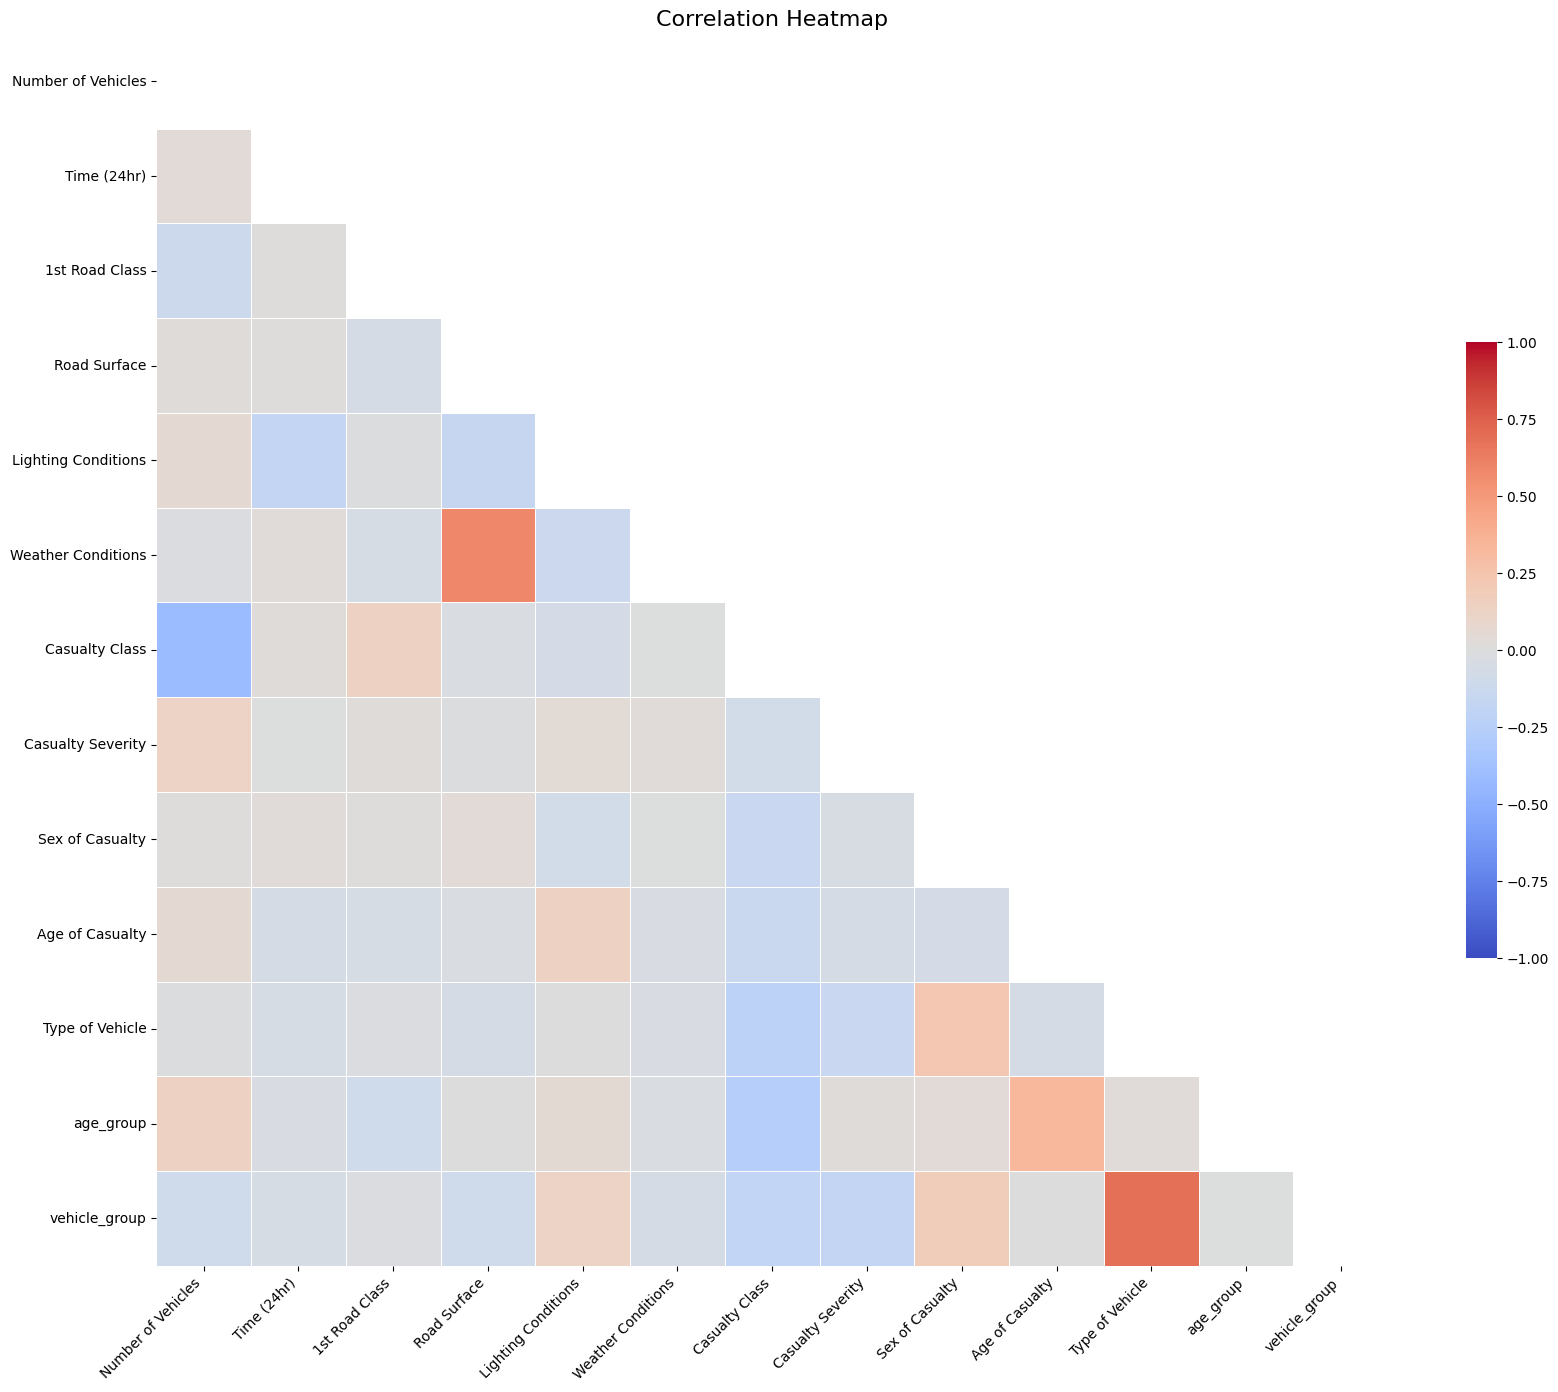

In [80]:
# calculate the correlation matrix
corr = df.corr()
#  lower triangle of the matrix
mask = np.triu(np.ones_like(corr, dtype=bool))
# Set up the matplotlib figure
plt.figure(figsize=(20, 16))
sns.heatmap(corr, mask=mask, annot=False, cmap='coolwarm', vmin=-1, vmax=1, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5},
            xticklabels=True, yticklabels=True)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.yticks(rotation=0, fontsize=10)
plt.title('Correlation Heatmap', fontsize=16)
plt.show()

Insights:
- there is a slight negative correlation between number of vehicles and casualty class.

- there is a weak positive correlation between Lighting Conditions and Casualty Severity, This might suggest that better lighting conditions could be associated with higher severity of casualties, but the correlation is weak.

- there is a weak positive correlation between Type of Vehicle and Road Surface , This indicates that the type of vehicle might be somewhat related to the road surface condition during the incident.

- there is a slight positive correlation between Weather Conditions and Lighting Conditions
As no variables are significanlty correlated, we will work on all features we have

We won't perform feature selection as we have few columns to model

## Data Preparation

In [25]:
df.head()

,Number of Vehicles,Time (24hr),1st Road Class,Road Surface,Lighting Conditions,Weather Conditions,Casualty Class,Casualty Severity,Sex of Casualty,Age of Casualty,Type of Vehicle,age_group,vehicle_group
0,2,712,1,2,1,5,0,2,1,62,2,7,0
1,2,830,4,2,4,5,0,2,0,39,2,4,0
2,1,1215,0,2,4,1,2,1,1,66,2,7,0
3,1,1735,0,0,2,1,2,1,1,39,3,4,1
4,2,1230,0,0,4,1,0,2,1,29,2,3,0


In [26]:
# make train, test, and validation splits:
# make stratify ensure class presence in each splits
train_df, temp_df = train_test_split(df, test_size=0.4, random_state=42, stratify=df['Casualty Class'])
val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42, stratify=temp_df['Casualty Class'])
# separate features and target
X_train = train_df.drop(columns=['Casualty Class'])
y_train = train_df['Casualty Class']
X_val = val_df.drop(columns=['Casualty Class'])
y_val = val_df['Casualty Class']
X_test = test_df.drop(columns=['Casualty Class'])
y_test = test_df['Casualty Class']

In [27]:
# scale data - xtrain and x val only to avoid data leakage
# handle the time in hours columns by power transformaer
pt_yeojohnson = PowerTransformer(method='yeo-johnson')
X_train['Time (24hr)'] = pt_yeojohnson.fit_transform(X_train[['Time (24hr)']])
# apply stansard scaler which is better in handling outliers
for col in X_train:
    ss = StandardScaler()
    X_train[col] = ss.fit_transform(X_train[[col]])
X_val['Time (24hr)'] = pt_yeojohnson.transform(X_val[['Time (24hr)']])
for col in X_val:
    ss = StandardScaler()
    X_val[col] = ss.fit_transform(X_val[[col]])


In [28]:
#handle Class Imbalance using SMOTE
smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)

# display the transformed, scaled, and balanced training DataFrame
print("\nTransformed, Scaled, and Balanced Training Target:")
print(y_train_balanced.value_counts())
print("\nValidation Target Distribution:")
print(y_val.value_counts())
print("\nTesting Target Distribution:")
print(y_test.value_counts())


Transformed, Scaled, and Balanced Training Target:
Casualty Class
1    929
2    929
0    929
Name: count, dtype: int64

Validation Target Distribution:
Casualty Class
0    310
1    140
2     67
Name: count, dtype: int64

Testing Target Distribution:
Casualty Class
0    310
1    141
2     67
Name: count, dtype: int64


## Modeling

Based on a review of similar work on kaggle on similar dataset, we will try randomforest, logistic regression, gradientboosting, and exgbbost. We will try model like balanced random forest that is customsed for imabalance learning

In [36]:
# define the pipeline
from sklearn.base import BaseEstimator, TransformerMixin

class DummyClassifier(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None): return self
    def transform(self, X): return X

# Define pipeline with placeholder
pipeline = Pipeline([
    ('power_transform', PowerTransformer(method='yeo-johnson')),
    ('scaler', StandardScaler()),
    ('classifier', DummyClassifier())
])

# Parameter grid
param_dist = [
    {
        'classifier': [LogisticRegression(random_state=42, multi_class='multinomial', solver='lbfgs')],
        'classifier__C': uniform(0.1, 100)
    },
    {
        'classifier': [BalancedRandomForestClassifier(random_state=42)],
        'classifier__n_estimators': randint(50, 200),
        'classifier__max_depth': [None, 10, 20, 30]
    },
    {
        'classifier': [RandomForestClassifier(random_state=42)],
        'classifier__n_estimators': randint(50, 200),
        'classifier__max_depth': [None, 10, 20, 30]
    },
    {
        'classifier': [xgb.XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='mlogloss')],
        'classifier__n_estimators': randint(50, 200),
        'classifier__max_depth': randint(3, 10),
        'classifier__learning_rate': uniform(0.01, 0.3)
    },
    {
        'classifier': [GradientBoostingClassifier(random_state=42)],
        'classifier__n_estimators': randint(50, 200),
        'classifier__max_depth': randint(3, 10),
        'classifier__learning_rate': uniform(0.01, 0.3)
    }
]


# f1_score as the scoring metric
scorer = make_scorer(f1_score, average='macro')

#  using random search to fine tune the models based on a gris of parameters
random_search = RandomizedSearchCV(estimator=pipeline, param_distributions=param_dist, cv=5, scoring=scorer, n_iter=50, n_jobs=-1, random_state=42)
# fit RandomizedSearchCV
random_search.fit(X_train, y_train)

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('power_transform',
                                              PowerTransformer()),
                                             ('scaler', StandardScaler()),
                                             ('classifier',
                                              DummyClassifier())]),
                   n_iter=50, n_jobs=-1,
                   param_distributions=[{'classifier': [LogisticRegression(multi_class='multinomial',
                                                                           random_state=42)],
                                         'classifier__C': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at...
                                         'classifier__learning_rate': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x797522368c10>,
                                         'classifier__max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x79752236b690>,
                                         'classifier__n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x79751ee776d0>}],
                   random_state=42,
                   scoring=make_scorer(f1_score, response_method='predict', average=macro))

In [37]:

# get best parameters and estimator
best_params = random_search.best_params_
best_model = random_search.best_estimator_

print(f"Best Parameters: {best_params}")


Best Parameters: {'classifier': RandomForestClassifier(random_state=42), 'classifier__max_depth': None, 'classifier__n_estimators': 185}


Validation Set Evaluation with Best Model:
[[265  32  13]
 [ 61  72   7]
 [  9   5  53]]
              precision    recall  f1-score   support

           0       0.79      0.85      0.82       310
           1       0.66      0.51      0.58       140
           2       0.73      0.79      0.76        67

    accuracy                           0.75       517
   macro avg       0.73      0.72      0.72       517
weighted avg       0.75      0.75      0.75       517



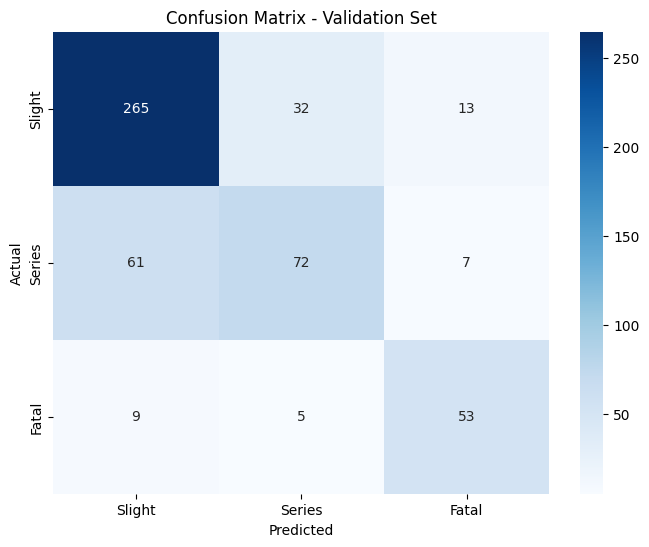

In [38]:

# evaluate the best model on the validation set
y_val_pred_best = best_model.predict(X_val)

print("Validation Set Evaluation with Best Model:")
print(confusion_matrix(y_val, y_val_pred_best))
print(classification_report(y_val, y_val_pred_best))
conf_matrix_val = confusion_matrix(y_val, y_val_pred_best)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_val, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Slight', 'Series','Fatal'],
            yticklabels=['Slight', 'Series','Fatal'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Validation Set')
plt.show()


Test Set Evaluation with Best Model:
[[308   2   0]
 [139   2   0]
 [ 65   2   0]]
              precision    recall  f1-score   support

           0       0.60      0.99      0.75       310
           1       0.33      0.01      0.03       141
           2       0.00      0.00      0.00        67

    accuracy                           0.60       518
   macro avg       0.31      0.34      0.26       518
weighted avg       0.45      0.60      0.46       518



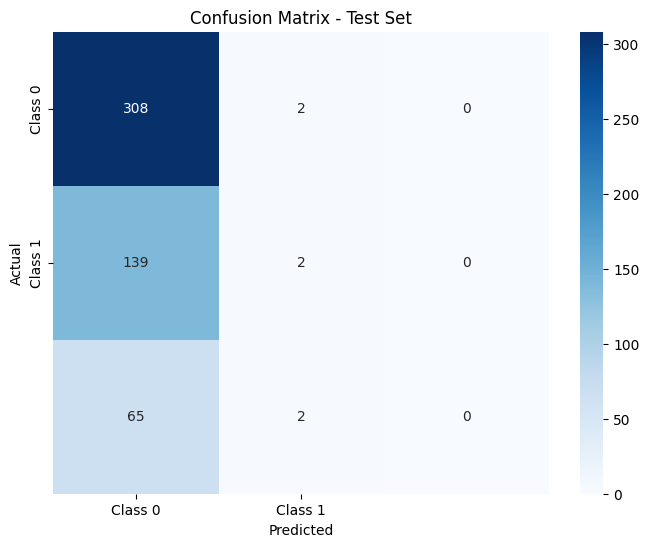

In [41]:
# evaluate the best model on the test set
y_test_pred_best = best_model.predict(X_test)

print("Test Set Evaluation with Best Model:")
print(confusion_matrix(y_test, y_test_pred_best))
print(classification_report(y_test, y_test_pred_best))

# Plot confusion matrix for test set
conf_matrix_test = confusion_matrix(y_test, y_test_pred_best)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_test, annot=True,
            fmt='d', cmap='Blues',
            xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Test Set')
plt.show()

#### Communicate finding:

   - High accuracy for "Slight" (Class 0) in both sets.
   - Struggles with "Serious" (Class 1) and "Fatal" (Class 2), worse in the test set.
- **Validation Set**:
     - Mix-up between "Slight" and "Serious"; "Serious" often misclassified as "Slight."
     - "Fatal" often misclassified as "Slight."
   - **Test Set**:
     - Many "Class 1" cases misclassified as "Class 0."
     - No correct classifications for "Class 2."
   **Sensitivity to 'Serious' and 'Fatal'**:
   - Poor sensitivity for "Serious" and "Fatal" in both sets.

##### Recommendations for Improvement
1. more feature engineeringto enhance features to better capture the differences between classes, especially for "Serious" and "Fatal."
2. use different oversampling, undersampling, or synthetic data generation techniques
3. Consider more complex models
4.  tune hyperparameters in larger scope of parametetrs, focusing on improving recall for "Serious" and "Fatal" classes.
5.  gather more data for underrepresented classes to improve the model's ability to generalize.

Convert notebook to html

In [ ]:
import joblib

# ✅ تحميل PowerTransformer
power_transformer = joblib.load("api/power_transformer.pkl")

# ✅ طباعة عدد الميزات التي تم تدريب `PowerTransformer` عليها
print(f"✅ PowerTransformer تم على {power_transformer.n_features_in_} ميزات.")


✅ PowerTransformer تم تدريبه على 1 ميزات.


In [ ]:
import pandas as pd
import joblib
from sklearn.preprocessing import LabelEncoder

df = pd.read_excel("Road Accidents.xlsx")

def handle_age(age):
    if age < 70:
        return f"{(age // 10) * 10}-{((age // 10) * 10) + 9}"
    else:
        return "+70"
df['age_group'] = df['Age of Casualty'].apply(handle_age)

vehicle_group_mapping = {
    'Car': 'Car',
    'Taxi/Private hire car': 'Car',
    'Pedal cycle': 'Two-Wheeled Vehicle',
    'Motorcycle over 50cc and up to 125cc': 'Two-Wheeled Vehicle',
    'Motorcycle over 500cc': 'Two-Wheeled Vehicle',
    'M/cycle 50cc and under': 'Two-Wheeled Vehicle',
    'Motorcycle over 125cc and up to 500cc': 'Two-Wheeled Vehicle',
    'Bus or coach (17 or more passenger seats)': 'Public Transportation',
    'Minibus (8 – 16 passenger seats)': 'Public Transportation',
    'Goods vehicle 3.5 tonnes mgw and under': 'Other Vehicle',
    'Goods vehicle 7.5 tonnes mgw and over': 'Other Vehicle',
    'Goods vehicle over 3.5 tonnes and under 7.5 tonnes mgw': 'Other Vehicle',
    'Other Vehicle': 'Other Vehicle',
    'Ridden horse': 'Other Vehicle',
    'Agricultural vehicle (includes diggers etc.)': 'Other Vehicle'
}
df['vehicle_group'] = df['Type of Vehicle'].map(vehicle_group_mapping)

categorical_columns = [
    "1st Road Class",
    "Road Surface",
    "Lighting Conditions",
    "Weather Conditions",
    "Casualty Severity",
    "Sex of Casualty",
    "Type of Vehicle",
    "age_group",
    "vehicle_group"
]

for col in categorical_columns:
    df[col] = df[col].astype(str)

label_encoders = {}

for col in categorical_columns:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])    
    label_encoders[col] = {"encoder": le, "classes": list(le.classes_)}  # حفظ القيم الأصلية أيضًا

    print(f" values '{col}': {list(le.classes_)}")

joblib.dump(label_encoders, "api/label_encoders.pkl")



 values '1st Road Class': ['A', 'A(M)', 'B', 'Motorway', 'Unclassified']
 values 'Road Surface': ['5', 'Dry', 'Frost / Ice', 'Wet / Damp']
 values 'Lighting Conditions': ['Darkness: no street lighting', 'Darkness: street lighting unknown', 'Darkness: street lights present and lit', 'Darkness: street lights present but unlit', 'Daylight: street lights present']
 values 'Weather Conditions': ['Fine with high winds', 'Fine without high winds', 'Fog or mist – if hazard', 'Other', 'Raining with high winds', 'Raining without high winds', 'Unknown']
 values 'Casualty Severity': ['Fatal', 'Serious', 'Slight']
 values 'Sex of Casualty': ['Female', 'Male']
 values 'Type of Vehicle': ['Agricultural vehicle (includes diggers etc.)', 'Bus or coach (17 or more passenger seats)', 'Car', 'Goods vehicle 3.5 tonnes mgw and under', 'Goods vehicle 7.5 tonnes mgw and over', 'Goods vehicle over 3.5 tonnes and under 7.5 tonnes mgw', 'M/cycle 50cc and under', 'Minibus (8 – 16 passenger seats)', 'Motorcycle ov

['api/label_encoders.pkl']